In [1]:
from src.est import *
from src.utils import *

SEED = 1000
num_cpus = os.cpu_count() // 2
np.random.seed(SEED)
os.environ['OMP_NUM_THREADS'] = str(num_cpus)
verbose = False

In [2]:
num_trials = 10

N = torch.tensor([5,5]) # No. states per dimension
Ntot = N.prod().item() # Total no. states
K = 10 # Rank of model
D = len(N)

# ADMM termination conditions
eps_abs = 1e-6
eps_rel = 1e-6
eps_diff = 1e-6
lmbda_min = 1e-2
prob_min = 0.
verbose = False
normalize = True

num_samp = 5
T_range = np.logspace(1,5,num_samp).astype(int)
burn_in = 500

K_dclrm_range = np.round(np.linspace(0,1,3+1)[1:] * 12).astype(int)
K_slrm_range = np.round(np.linspace(0,1,3+1)[1:] * 12).astype(int)
K_lrt_range = np.round(float((2*Ntot+1)/(2*N.sum()+1)) * K_dclrm_range).astype(int)
gamma_range = np.logspace(-1,1,3)

lrt_args = {
    'K':None,
    'beta':None,
    'eps_abs':eps_abs,
    'eps_rel':eps_rel,
    'eps_diff':eps_diff,
    'lmbda_min':lmbda_min,
    'prob_min':prob_min,
    'max_itr':None,
    'verbose':False,
    'MARG_CONST':True,
    'ACCEL':False,
    'disable_tqdm':False
}

nnlrm_args = {
    'beta':None,
    'gamma':None,
    'eps_abs':eps_abs,
    'eps_rel':eps_rel,
    'eps_diff':eps_diff,
    'prob_min':prob_min,
    'max_itr':None,
    'verbose':False,
    'disable_tqdm':False
}

dclrm_args = {
    'K':None,
    'c':None,
    'alpha':None,
    'beta':None,
    'eps_abs':eps_abs,
    'eps_rel':eps_rel,
    'eps_diff':eps_diff,
    'prob_min':prob_min,
    'max_itr':None,
    'admm_itr':1,
    'verbose':False
}

Text(0.5, 1.0, 'Joint PMF')

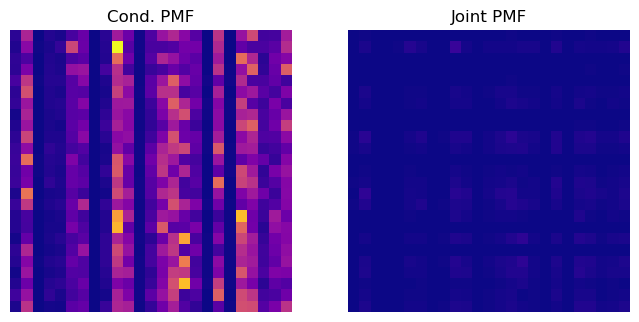

In [3]:
# Generate low-rank matrix model for given number of trials

mcs = []
P_tru = []; Q_tru = []; P_1D_tru = []; Q_1D_tru = []
for t in range(num_trials):
    mc = generate_lowrankmatrix_model(Ntot,K)
    # mc = generate_lowranktensor_model(N,K) # Generate low-rank tensor model
    mcs.append(mc)

    # P_1D_tru.append(mc.P.reshape(Ntot,Ntot))
    # Q_1D_tru.append(mc.Q.reshape(Ntot,Ntot))
    # P_tru.append(mc.P.clone())
    # Q_tru.append(mc.Q.clone())

    P_tru.append(mc.P.reshape(tuple(N.repeat(2))))
    Q_tru.append(mc.Q.reshape(tuple(N.repeat(2))))
    P_1D_tru.append(mc.P.clone())
    Q_1D_tru.append(mc.Q.clone())


erank_P_tru = torch.tensor([erank(P_1D_tru[t]) for t in range(num_trials)]).to(torch.float)
rank_P_tru = torch.tensor([torch.linalg.matrix_rank(P_1D_tru[t]) for t in range(num_trials)]).to(torch.float)
erank_Q_tru = torch.tensor([erank(Q_1D_tru[t]) for t in range(num_trials)]).to(torch.float)
rank_Q_tru = torch.tensor([torch.linalg.matrix_rank(Q_1D_tru[t]) for t in range(num_trials)]).to(torch.float)

t = 0
if normalize:
    vmin = torch.minimum(P_tru[t].min(),Q_tru[t].min())
    vmax = torch.maximum(P_tru[t].max(),Q_tru[t].max())
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
if normalize:
    ax[0].imshow(P_1D_tru[t],'plasma',vmin=vmin,vmax=vmax); ax[1].imshow(Q_1D_tru[t],'plasma',vmin=vmin,vmax=vmax)
else:
    ax[0].imshow(P_1D_tru[t],'plasma'); ax[1].imshow(Q_1D_tru[t],'plasma')
ax[0].set_title('Cond. PMF'); ax[1].set_title('Joint PMF')

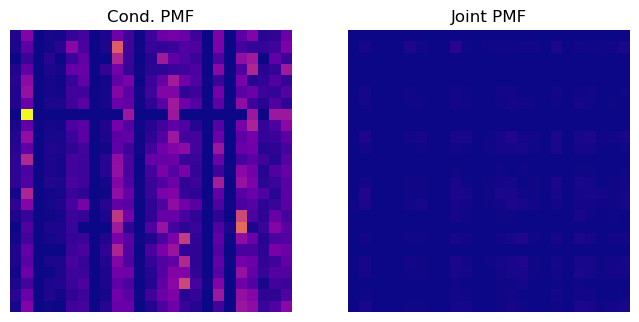

In [4]:
# Generate observed trajectories

Xtot = [mcs[t].simulate(T_range[-1]+burn_in)[burn_in:] for _ in range(num_trials)]

P_1D_obs = [[] for _ in range(num_trials)]
Q_1D_obs = [[] for _ in range(num_trials)]
Mask_1D = [[] for _ in range(num_trials)]
P_obs = [[] for _ in range(num_trials)]
Q_obs = [[] for _ in range(num_trials)]
Mask = [[] for _ in range(num_trials)]
for t in range(num_trials):
    for T in T_range:
        # Ph,Qh,M = estimate_empirical_tensor(Xtot[t][:T],N)
        # Ph_1D = Ph.reshape(Ntot,Ntot); Qh_1D = Qh.reshape(Ntot,Ntot); M_1D = M.reshape(Ntot,Ntot)

        Ph_1D,Qh_1D,M_1D = estimate_empirical_matrix(Xtot[t][:T],Ntot)
        Ph = Ph_1D.reshape(tuple(N.repeat(2))); Qh = Qh_1D.reshape(tuple(N.repeat(2))); M = M_1D.reshape(tuple(N.repeat(2)))

        P_1D_obs[t].append(Ph_1D); Q_1D_obs[t].append(Qh_1D); P_obs[t].append(Ph); Q_obs[t].append(Qh)
        Mask_1D[t].append(1-M_1D.to(int)); Mask[t].append(1-M.to(int))

t = 0; i = -1
normalize = True
if normalize:
    vmin = torch.minimum(P_1D_obs[t][i].min(),Q_1D_obs[t][i].min())
    vmax = torch.maximum(P_1D_obs[t][i].max(),Q_1D_obs[t][i].max())
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
if normalize:
    ax[0].imshow(P_1D_obs[t][i],'plasma',vmin=vmin,vmax=vmax); ax[1].imshow(Q_1D_obs[t][i],'plasma',vmin=vmin,vmax=vmax)
else:
    ax[0].imshow(P_1D_obs[t][i],'plasma'); ax[1].imshow(Q_1D_obs[t][i],'plasma')
ax[0].set_title('Cond. PMF'); ax[1].set_title('Joint PMF')

rank_P_obs = torch.tensor([[torch.linalg.matrix_rank(P_1D_obs[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
erank_P_obs = torch.tensor([[erank(P_1D_obs[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
rank_Q_obs = torch.tensor([[torch.linalg.matrix_rank(Q_1D_obs[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)
erank_Q_obs = torch.tensor([[erank(Q_1D_obs[t][i]) for i in range(len(T_range))] for t in range(num_trials)]).to(torch.float)

err_obs_P = {
    'frob':torch.tensor([[frob_err(P_1D_obs[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)]),
    'normfrob':torch.tensor([[normfrob_err(P_1D_obs[t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)]),
    'l1':torch.tensor([[l1_err(P_1D_obs[t][i],P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)]),
    'norml1':torch.tensor([[norml1_err(P_1D_obs[t][i],P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)]),
    'sin':torch.tensor([[sin_err(P_1D_obs[t][i],P_1D_tru[t],int(rank_P_tru[t])) for i in range(len(T_range))] for t in range(num_trials)]),
    'sinL':torch.tensor([[sin_err(P_1D_obs[t][i],P_1D_tru[t],int(rank_P_tru[t]),'left') for i in range(len(T_range))] for t in range(num_trials)]),
    'sinR':torch.tensor([[sin_err(P_1D_obs[t][i],P_1D_tru[t],int(rank_P_tru[t]),'right') for i in range(len(T_range))] for t in range(num_trials)]) }
err_obs_Q = {
    'frob':torch.tensor([[frob_err(Q_1D_obs[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)]),
    'normfrob':torch.tensor([[normfrob_err(Q_1D_obs[t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)]),
    'l1':torch.tensor([[l1_err(Q_1D_obs[t][i],Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)]),
    'norml1':torch.tensor([[norml1_err(Q_1D_obs[t][i],Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)]),
    'sin':torch.tensor([[sin_err(Q_1D_obs[t][i],Q_1D_tru[t],int(rank_Q_tru[t])) for i in range(len(T_range))] for t in range(num_trials)]),
    'sinL':torch.tensor([[sin_err(Q_1D_obs[t][i],Q_1D_tru[t],int(rank_Q_tru[t]),'left') for i in range(len(T_range))] for t in range(num_trials)]),
    'sinR':torch.tensor([[sin_err(Q_1D_obs[t][i],Q_1D_tru[t],int(rank_Q_tru[t]),'right') for i in range(len(T_range))] for t in range(num_trials)])
}

gamma: 0.100


  0%|          | 0/10000 [00:00<?, ?it/s]

gamma: 1.000


  0%|          | 0/10000 [00:00<?, ?it/s]

gamma: 10.000


  1%|          | 65/10000 [00:00<00:06, 1460.13it/s]


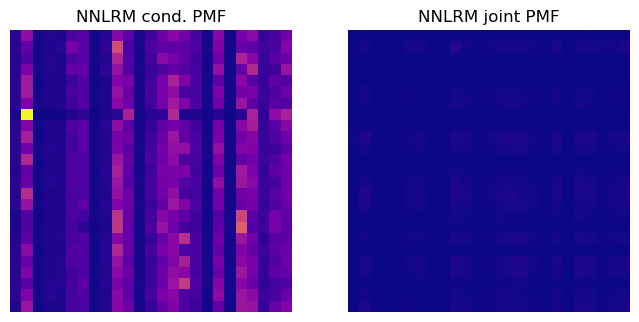

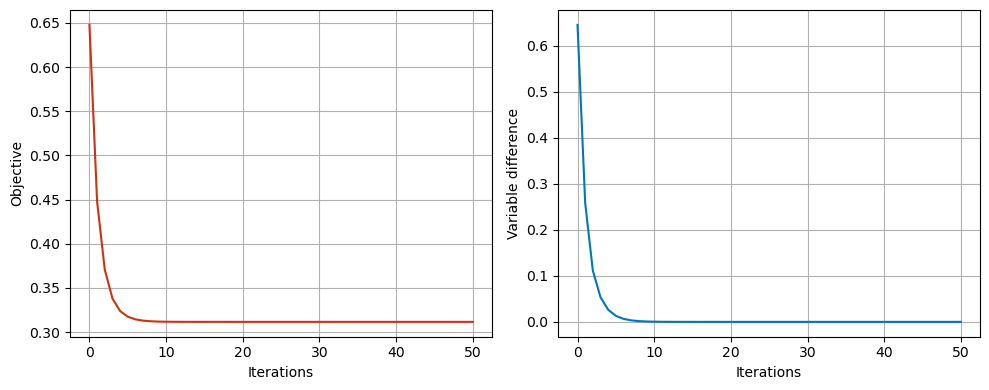

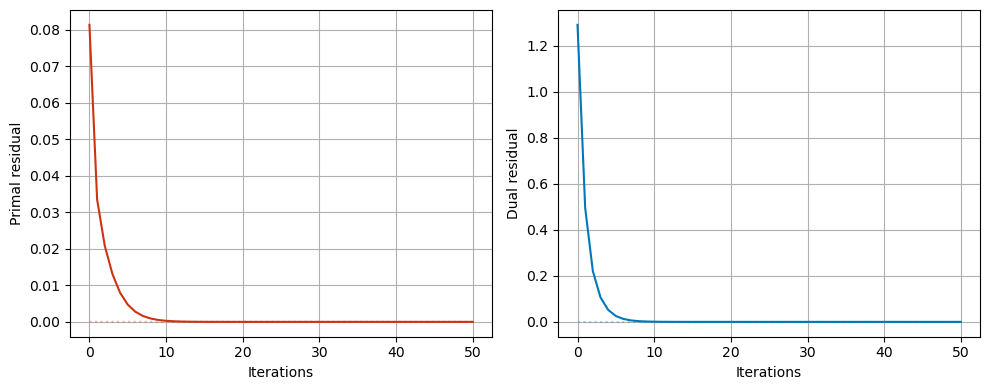

In [5]:
# Nuclear norm matrix estimation

nnlrme_est_parallel = lambda nnlrm,Ph,args: nnlrm.estimate(Ph,args)

nnlrm_args['beta'] = 1.
nnlrm_args['max_itr'] = 10000
nnlrm_args['min_itr'] = 50

nnlrme = [[[NucNormMatrixEstimator() for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(gamma_range))]
results_nnlrm = []
for j,gamma in enumerate(gamma_range):
    nnlrm_args['gamma'] = gamma
    print(f"gamma: {gamma:.3f}")
    results_nnlrm.append( Parallel(n_jobs=num_cpus)(delayed(nnlrme_est_parallel)( nnlrme[j][t][i],P_1D_obs[t][i],nnlrm_args ) for t in range(num_trials) for i in range(len(T_range))) )

P_1D_nnlrm = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(gamma_range))]
Q_1D_nnlrm = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(gamma_range))]
res_nnlrm = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(gamma_range))]
for j in range(len(gamma_range)):
    c = 0
    for t in range(num_trials):
        for i in range(len(T_range)):
            P_1D_nnlrm[j][t][i] = results_nnlrm[j][c][0].P
            Q_1D_nnlrm[j][t][i] = results_nnlrm[j][c][0].Q
            res_nnlrm[j][t][i] = results_nnlrm[j][c][1]
            c+=1

j = 0; t = 0; i = -1
if normalize:
    vmin = torch.minimum(P_1D_nnlrm[j][t][i].min(),Q_1D_nnlrm[j][t][i].min())
    vmax = torch.maximum(P_1D_nnlrm[j][t][i].max(),Q_1D_nnlrm[j][t][i].max())
    # vmin = 0; vmax = 1
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
if normalize:
    ax[0].imshow(P_1D_nnlrm[j][t][i],'plasma',vmin=vmin,vmax=vmax); ax[1].imshow(Q_1D_nnlrm[j][t][i],'plasma',vmin=vmin,vmax=vmax)
else:
    ax[0].imshow(P_1D_nnlrm[j][t][i],'plasma'); ax[1].imshow(Q_1D_nnlrm[j][t][i],'plasma')
ax[0].set_title('NNLRM cond. PMF'); ax[1].set_title('NNLRM joint PMF')

fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_nnlrm[j][t][i]['admm_obj'],'-',c=vib_qual['red'])
ax[1].plot(res_nnlrm[j][t][i]['admm_var'],'-',c=vib_qual['blue'])
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Objective'); ax[1].set_ylabel('Variable difference')
fig.tight_layout()

fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_nnlrm[j][t][i]['admm_res'][0],'-',c=vib_qual['red'])
ax[0].plot(res_nnlrm[j][t][i]['admm_res'][2],':',c=vib_qual['red'],alpha=.3)
ax[1].plot(res_nnlrm[j][t][i]['admm_res'][1],'-',c=vib_qual['blue'])
ax[1].plot(res_nnlrm[j][t][i]['admm_res'][3],':',c=vib_qual['blue'],alpha=.3)
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Primal residual'); ax[1].set_ylabel('Dual residual')
fig.tight_layout()

rank_P_nnlrm = torch.tensor([[[torch.linalg.matrix_rank(P_1D_nnlrm[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_nnlrm))]).to(torch.float)
erank_P_nnlrm = torch.tensor([[[erank(P_1D_nnlrm[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_nnlrm))]).to(torch.float)
rank_Q_nnlrm = torch.tensor([[[torch.linalg.matrix_rank(Q_1D_nnlrm[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_nnlrm))]).to(torch.float)
erank_Q_nnlrm = torch.tensor([[[erank(Q_1D_nnlrm[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_nnlrm))]).to(torch.float)

err_nnlrm_P = {
    'frob':torch.tensor([[[frob_err(P_1D_nnlrm[j][t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_nnlrm))]),
    'normfrob':torch.tensor([[[normfrob_err(P_1D_nnlrm[j][t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_nnlrm))]),
    'l1':torch.tensor([[[l1_err(P_1D_nnlrm[j][t][i],P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_nnlrm))]),
    'norml1':torch.tensor([[[norml1_err(P_1D_nnlrm[j][t][i],P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_nnlrm))]),
    'sin':torch.tensor([[[sin_err(P_1D_nnlrm[j][t][i],P_1D_tru[t],int(rank_P_tru[t])) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_nnlrm))]),
    'sinL':torch.tensor([[[sin_err(P_1D_nnlrm[j][t][i],P_1D_tru[t],int(rank_P_tru[t]),'left') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_nnlrm))]),
    'sinR':torch.tensor([[[sin_err(P_1D_nnlrm[j][t][i],P_1D_tru[t],int(rank_P_tru[t]),'right') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_nnlrm))]) }
err_nnlrm_Q = {
    'frob':torch.tensor([[[frob_err(Q_1D_nnlrm[j][t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_nnlrm))]),
    'normfrob':torch.tensor([[[normfrob_err(Q_1D_nnlrm[j][t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_nnlrm))]),
    'l1':torch.tensor([[[l1_err(Q_1D_nnlrm[j][t][i],Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_nnlrm))]),
    'norml1':torch.tensor([[[norml1_err(Q_1D_nnlrm[j][t][i],Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_nnlrm))]),
    'sin':torch.tensor([[[sin_err(Q_1D_nnlrm[j][t][i],Q_1D_tru[t],int(rank_Q_tru[t])) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_nnlrm))]),
    'sinL':torch.tensor([[[sin_err(Q_1D_nnlrm[j][t][i],Q_1D_tru[t],int(rank_Q_tru[t]),'left') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_nnlrm))]),
    'sinR':torch.tensor([[[sin_err(Q_1D_nnlrm[j][t][i],Q_1D_tru[t],int(rank_Q_tru[t]),'right') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_nnlrm))]) }

Rank: 4


  1%|          | 53/5000 [00:00<00:09, 523.69it/s]

Rank: 8


  0%|          | 0/5000 [00:00<?, ?it/s]

Rank: 12


100%|██████████| 5000/5000 [00:08<00:00, 612.53it/s]


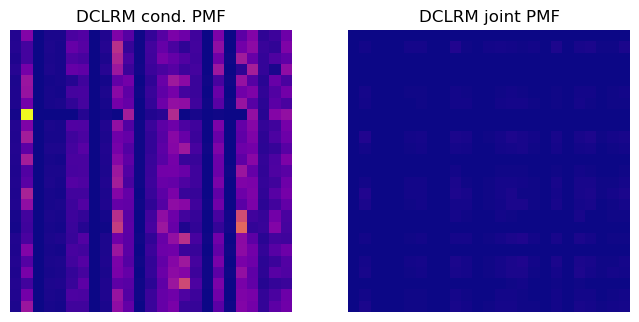

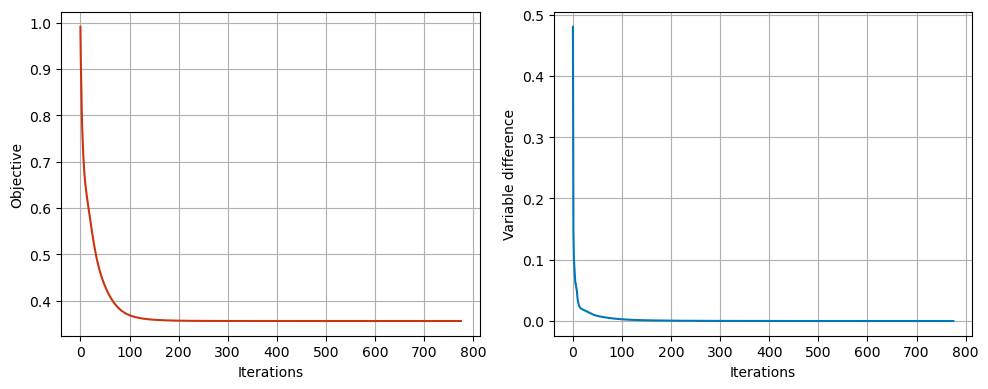

In [6]:
# Low-rank matrix estimation via DC algorithm

dclrme_est_parallel = lambda dclrm,Ph,args: dclrm.estimate(Ph,args)

dclrm_args['c'] = 5.
dclrm_args['alpha'] = .5
dclrm_args['beta'] = 1.
dclrm_args['max_itr'] = 5000
dclrm_args['min_itr'] = 50
dclrm_args['admm_itr'] = 1

dclrme = [[[DCLowRankMatrixEstimator() for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_dclrm_range))]
results_dclrm = []
for j,K in enumerate(K_dclrm_range):
    dclrm_args['K'] = K
    print(f"Rank: {K}")
    results_dclrm.append( Parallel(n_jobs=num_cpus)(delayed(dclrme_est_parallel)( dclrme[j][t][i],P_1D_obs[t][i],dclrm_args ) for t in range(num_trials) for i in range(len(T_range))) )

P_1D_dclrm = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_dclrm_range))]
Q_1D_dclrm = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_dclrm_range))]
res_dclrm = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_dclrm_range))]
for j in range(len(K_dclrm_range)):
    c = 0
    for t in range(num_trials):
        for i in range(len(T_range)):
            P_1D_dclrm[j][t][i] = results_dclrm[j][c][0].P
            Q_1D_dclrm[j][t][i] = results_dclrm[j][c][0].Q
            res_dclrm[j][t][i] = results_dclrm[j][c][1]
            c+=1

j = 0; t = 0; i = -1
if normalize:
    vmin = torch.minimum(P_1D_dclrm[j][t][i].min(),Q_1D_dclrm[j][t][i].min())
    vmax = torch.maximum(P_1D_dclrm[j][t][i].max(),Q_1D_dclrm[j][t][i].max())
    # vmin = 0; vmax = 1
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
if normalize:
    ax[0].imshow(P_1D_dclrm[j][t][i],'plasma',vmin=vmin,vmax=vmax); ax[1].imshow(Q_1D_dclrm[j][t][i],'plasma',vmin=vmin,vmax=vmax)
else:
    ax[0].imshow(P_1D_dclrm[j][t][i],'plasma'); ax[1].imshow(Q_1D_dclrm[j][t][i],'plasma')
ax[0].set_title('DCLRM cond. PMF'); ax[1].set_title('DCLRM joint PMF')

fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_dclrm[j][t][i]['admm_obj'],'-',c=vib_qual['red'])
ax[1].plot(res_dclrm[j][t][i]['admm_var'],'-',c=vib_qual['blue'])
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Objective'); ax[1].set_ylabel('Variable difference')
fig.tight_layout()

rank_P_dclrm = torch.tensor([[[torch.linalg.matrix_rank(P_1D_dclrm[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_dclrm))]).to(torch.float)
erank_P_dclrm = torch.tensor([[[erank(P_1D_dclrm[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_dclrm))]).to(torch.float)
rank_Q_dclrm = torch.tensor([[[torch.linalg.matrix_rank(Q_1D_dclrm[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_dclrm))]).to(torch.float)
erank_Q_dclrm = torch.tensor([[[erank(Q_1D_dclrm[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_dclrm))]).to(torch.float)

err_dclrm_P = {
    'frob':torch.tensor([[[frob_err(P_1D_dclrm[j][t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_dclrm))]),
    'normfrob':torch.tensor([[[normfrob_err(P_1D_dclrm[j][t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_dclrm))]),
    'l1':torch.tensor([[[l1_err(P_1D_dclrm[j][t][i],P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_dclrm))]),
    'norml1':torch.tensor([[[norml1_err(P_1D_dclrm[j][t][i],P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_dclrm))]),
    'sin':torch.tensor([[[sin_err(P_1D_dclrm[j][t][i],P_1D_tru[t],int(rank_P_tru[t])) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_dclrm))]),
    'sinL':torch.tensor([[[sin_err(P_1D_dclrm[j][t][i],P_1D_tru[t],int(rank_P_tru[t]),'left') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_dclrm))]),
    'sinR':torch.tensor([[[sin_err(P_1D_dclrm[j][t][i],P_1D_tru[t],int(rank_P_tru[t]),'right') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_dclrm))]) }
err_dclrm_Q = {
    'frob':torch.tensor([[[frob_err(Q_1D_dclrm[j][t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_dclrm))]),
    'normfrob':torch.tensor([[[normfrob_err(Q_1D_dclrm[j][t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_dclrm))]),
    'l1':torch.tensor([[[l1_err(Q_1D_dclrm[j][t][i],Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_dclrm))]),
    'norml1':torch.tensor([[[norml1_err(Q_1D_dclrm[j][t][i],Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_dclrm))]),
    'sin':torch.tensor([[[sin_err(Q_1D_dclrm[j][t][i],Q_1D_tru[t],int(rank_Q_tru[t])) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_dclrm))]),
    'sinL':torch.tensor([[[sin_err(Q_1D_dclrm[j][t][i],Q_1D_tru[t],int(rank_Q_tru[t]),'left') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_dclrm))]),
    'sinR':torch.tensor([[[sin_err(Q_1D_dclrm[j][t][i],Q_1D_tru[t],int(rank_Q_tru[t]),'right') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_dclrm))]) }

Rank: 4
Rank: 8
Rank: 12


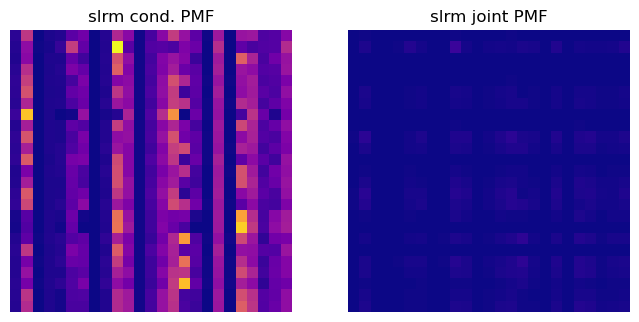

In [7]:
# Spectral low-rank matrix estimation

slrme_est_parallel = lambda slrm,Qh,K,p: slrm.estimate(Qh,K,p)

slrme = [[[SpecLowRankMatrixEstimator() for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_slrm_range))]
results_slrm = []
for j,K in enumerate(K_slrm_range):
    K_slrme = K
    print(f"Rank: {K}")
    results_slrm.append( Parallel(n_jobs=num_cpus)(delayed(slrme_est_parallel)( slrme[j][t][i],Q_1D_obs[t][i],K_slrme, prob_min ) for t in range(num_trials) for i in range(len(T_range))) )

P_1D_slrm = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_slrm_range))]
Q_1D_slrm = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_slrm_range))]
res_slrm = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_slrm_range))]
for j in range(len(K_slrm_range)):
    c = 0
    for t in range(num_trials):
        for i in range(len(T_range)):
            P_1D_slrm[j][t][i] = results_slrm[j][c][0].P
            Q_1D_slrm[j][t][i] = results_slrm[j][c][0].Q
            res_slrm[j][t][i] = results_slrm[j][c][1]
            c+=1

j = 0; t = 0; i = -1
if normalize:
    vmin = torch.minimum(P_1D_slrm[j][t][i].min(),Q_1D_slrm[j][t][i].min())
    vmax = torch.maximum(P_1D_slrm[j][t][i].max(),Q_1D_slrm[j][t][i].max())
    # vmin = 0; vmax = 1
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
if normalize:
    ax[0].imshow(P_1D_slrm[j][t][i],'plasma',vmin=vmin,vmax=vmax); ax[1].imshow(Q_1D_slrm[j][t][i],'plasma',vmin=vmin,vmax=vmax)
else:
    ax[0].imshow(P_1D_slrm[j][t][i],'plasma'); ax[1].imshow(Q_1D_slrm[j][t][i],'plasma')
ax[0].set_title('slrm cond. PMF'); ax[1].set_title('slrm joint PMF')

rank_P_slrm = torch.tensor([[[torch.linalg.matrix_rank(P_1D_slrm[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_slrm))]).to(torch.float)
erank_P_slrm = torch.tensor([[[erank(P_1D_slrm[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_slrm))]).to(torch.float)
rank_Q_slrm = torch.tensor([[[torch.linalg.matrix_rank(Q_1D_slrm[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_slrm))]).to(torch.float)
erank_Q_slrm = torch.tensor([[[erank(Q_1D_slrm[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_slrm))]).to(torch.float)

err_slrm_P = {
    'frob':torch.tensor([[[frob_err(P_1D_slrm[j][t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_slrm))]),
    'normfrob':torch.tensor([[[normfrob_err(P_1D_slrm[j][t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_slrm))]),
    'l1':torch.tensor([[[l1_err(P_1D_slrm[j][t][i],P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_slrm))]),
    'norml1':torch.tensor([[[norml1_err(P_1D_slrm[j][t][i],P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_slrm))]),
    'sin':torch.tensor([[[sin_err(P_1D_slrm[j][t][i],P_1D_tru[t],int(rank_P_tru[t])) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_slrm))]),
    'sinL':torch.tensor([[[sin_err(P_1D_slrm[j][t][i],P_1D_tru[t],int(rank_P_tru[t]),'left') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_slrm))]),
    'sinR':torch.tensor([[[sin_err(P_1D_slrm[j][t][i],P_1D_tru[t],int(rank_P_tru[t]),'right') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_slrm))]) }
err_slrm_Q = {
    'frob':torch.tensor([[[frob_err(Q_1D_slrm[j][t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_slrm))]),
    'normfrob':torch.tensor([[[normfrob_err(Q_1D_slrm[j][t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_slrm))]),
    'l1':torch.tensor([[[l1_err(Q_1D_slrm[j][t][i],Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_slrm))]),
    'norml1':torch.tensor([[[norml1_err(Q_1D_slrm[j][t][i],Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_slrm))]),
    'sin':torch.tensor([[[sin_err(Q_1D_slrm[j][t][i],Q_1D_tru[t],int(rank_Q_tru[t])) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_slrm))]),
    'sinL':torch.tensor([[[sin_err(Q_1D_slrm[j][t][i],Q_1D_tru[t],int(rank_Q_tru[t]),'left') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_slrm))]),
    'sinR':torch.tensor([[[sin_err(Q_1D_slrm[j][t][i],Q_1D_tru[t],int(rank_Q_tru[t]),'right') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_slrm))]) }

Rank: 10


100%|██████████| 10000/10000 [00:34<00:00, 293.50it/s]


Rank: 19


  0%|          | 20/10000 [00:00<00:51, 195.02it/s]

Rank: 29


100%|██████████| 10000/10000 [00:43<00:00, 231.82it/s]


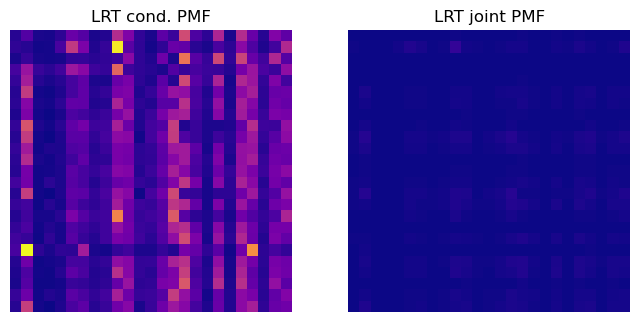

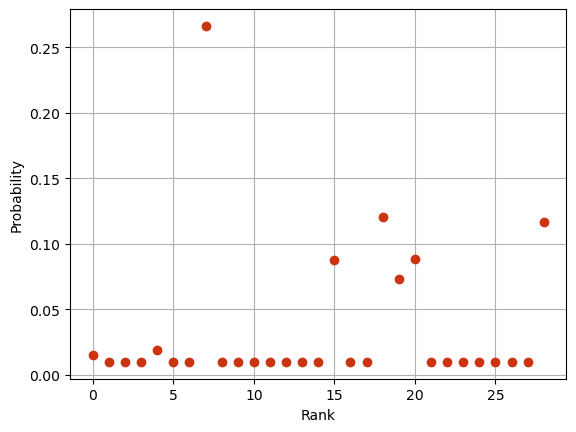

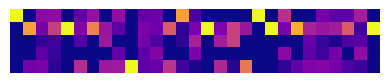

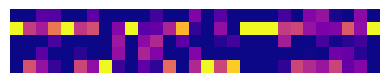

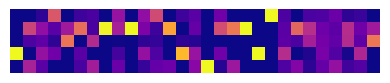

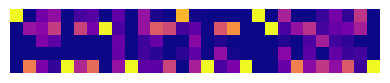

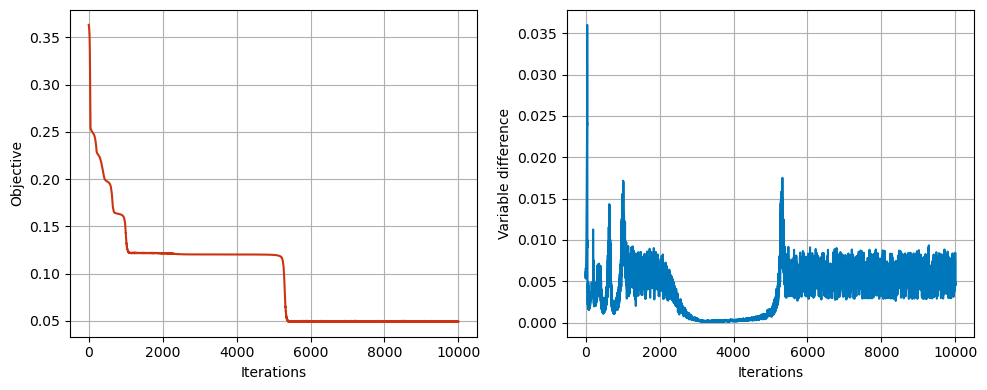

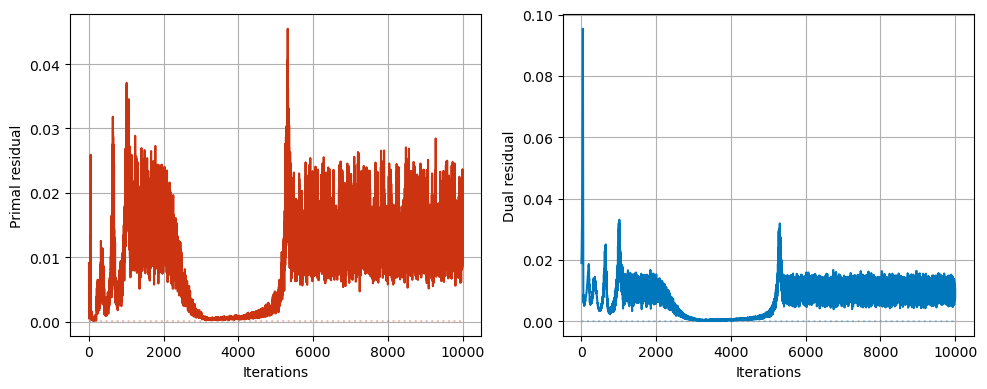

In [8]:
# Low-rank tensor estimation

# lrte_est_parallel = lambda lrte,Qh,lrt_args: lrte.estimate(Qh,lrt_args)
lrte_est_parallel = lambda lrte,Qh,M,lrt_args: lrte.estimate(Qh,M,lrt_args)

lrt_args['alpha'] = 100.
lrt_args['MARG_CONST'] = True
lrt_args['ACCEL'] = True
lrt_args['beta'] = 1.
lrt_args['max_itr'] = 10000
lrt_args['min_itr'] = 100

lrte = [[[LowRankTensorEstimator() for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_lrt_range))]
results_lrt = []
for j,K in enumerate(K_lrt_range):
    lrt_args['K'] = K
    print(f"Rank: {K}")
    results_lrt.append( Parallel(n_jobs=num_cpus)(delayed(lrte_est_parallel)( lrte[j][t][i],Q_obs[t][i],Mask[t][i],lrt_args ) for t in range(num_trials) for i in range(len(T_range))) )

P_1D_lrt = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_lrt_range))]
Q_1D_lrt = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_lrt_range))]
res_lrt = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_lrt_range))]
lmbda_lrt = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_lrt_range))]
Qfact_lrt = [[[None for _ in range(len(T_range))] for _ in range(num_trials)] for _ in range(len(K_lrt_range))]
for j in range(len(K_lrt_range)):
    c = 0
    for t in range(num_trials):
        for i in range(len(T_range)):
            P_1D_lrt[j][t][i] = results_lrt[j][c][0].P_1D
            Q_1D_lrt[j][t][i] = results_lrt[j][c][0].Q_1D
            res_lrt[j][t][i] = results_lrt[j][c][1]
            lmbda_lrt[j][t][i] = results_lrt[j][c][1]['lmbda']
            Qfact_lrt[j][t][i] = results_lrt[j][c][1]['Qfact']
            c+=1

j = 0; t = 0; i = -1
if normalize:
    vmin = torch.minimum(P_1D_lrt[j][t][i].min(),Q_1D_lrt[j][t][i].min())
    vmax = torch.maximum(P_1D_lrt[j][t][i].max(),Q_1D_lrt[j][t][i].max())
    # vmin = 0
    # vmax = 1
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]; _ = [a.axis('off') for a in ax]
if normalize:
    ax[0].imshow(P_1D_lrt[j][t][i],'plasma',vmin=vmin,vmax=vmax); ax[1].imshow(Q_1D_lrt[j][t][i],'plasma',vmin=vmin,vmax=vmax)
else:
    ax[0].imshow(P_1D_lrt[j][t][i],'plasma'); ax[1].imshow(Q_1D_lrt[j][t][i],'plasma')
ax[0].set_title('LRT cond. PMF'); ax[1].set_title('LRT joint PMF')

j = 2; t = 1; i = 0
fig = plt.figure(); ax = fig.subplots(); ax.grid(1); ax.set_axisbelow(1)
ax.plot( np.arange(K_lrt_range[j]), lmbda_lrt[j][t][i], 'o', c=vib_qual['red'] )
ax.set_xlabel("Rank"); ax.set_ylabel("Probability")
for d in range(2*D):
    madimshow(Qfact_lrt[j][t][i][d],'plasma',vmin=0,vmax=1,axis=0)

j = 0; t = 0; i = 0
fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_lrt[j][t][i]['admm_obj'],'-',c=vib_qual['red'])
ax[1].plot(res_lrt[j][t][i]['admm_var'],'-',c=vib_qual['blue'])
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Objective'); ax[1].set_ylabel('Variable difference')
fig.tight_layout()

fig = plt.figure(figsize=(2*5,4)); ax = fig.subplots(1,2); _ = [a.grid(1) for a in ax]; _ = [a.set_axisbelow(1) for a in ax]
ax[0].plot(res_lrt[j][t][i]['admm_res'][0],'-',c=vib_qual['red'])
ax[0].plot(res_lrt[j][t][i]['admm_res'][2],':',c=vib_qual['red'],alpha=.3)
ax[1].plot(res_lrt[j][t][i]['admm_res'][1],'-',c=vib_qual['blue'])
ax[1].plot(res_lrt[j][t][i]['admm_res'][3],':',c=vib_qual['blue'],alpha=.3)
_ = [[a.set_xlabel('Iterations')] for a in ax]; ax[0].set_ylabel('Primal residual'); ax[1].set_ylabel('Dual residual')
fig.tight_layout()

rank_P_lrt = torch.tensor([[[torch.linalg.matrix_rank(P_1D_lrt[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_lrt))]).to(torch.float)
erank_P_lrt = torch.tensor([[[erank(P_1D_lrt[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_lrt))]).to(torch.float)
rank_Q_lrt = torch.tensor([[[torch.linalg.matrix_rank(Q_1D_lrt[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_lrt))]).to(torch.float)
erank_Q_lrt = torch.tensor([[[erank(Q_1D_lrt[j][t][i]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_lrt))]).to(torch.float)

err_lrt_P = {
    'frob':torch.tensor([[[frob_err(P_1D_lrt[j][t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_lrt))]),
    'normfrob':torch.tensor([[[normfrob_err(P_1D_lrt[j][t][i],P_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_lrt))]),
    'l1':torch.tensor([[[l1_err(P_1D_lrt[j][t][i],P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_lrt))]),
    'norml1':torch.tensor([[[norml1_err(P_1D_lrt[j][t][i],P_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_lrt))]),
    'sin':torch.tensor([[[sin_err(P_1D_lrt[j][t][i],P_1D_tru[t],int(rank_P_tru[t])) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_lrt))]),
    'sinL':torch.tensor([[[sin_err(P_1D_lrt[j][t][i],P_1D_tru[t],int(rank_P_tru[t]),'left') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_lrt))]),
    'sinR':torch.tensor([[[sin_err(P_1D_lrt[j][t][i],P_1D_tru[t],int(rank_P_tru[t]),'right') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(P_1D_lrt))]) }
err_lrt_Q = {
    'frob':torch.tensor([[[frob_err(Q_1D_lrt[j][t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_lrt))]),
    'normfrob':torch.tensor([[[normfrob_err(Q_1D_lrt[j][t][i],Q_1D_tru[t])**2 for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_lrt))]),
    'l1':torch.tensor([[[l1_err(Q_1D_lrt[j][t][i],Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_lrt))]),
    'norml1':torch.tensor([[[norml1_err(Q_1D_lrt[j][t][i],Q_1D_tru[t]) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_lrt))]),
    'sin':torch.tensor([[[sin_err(Q_1D_lrt[j][t][i],Q_1D_tru[t],int(rank_Q_tru[t])) for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_lrt))]),
    'sinL':torch.tensor([[[sin_err(Q_1D_lrt[j][t][i],Q_1D_tru[t],int(rank_Q_tru[t]),'left') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_lrt))]),
    'sinR':torch.tensor([[[sin_err(Q_1D_lrt[j][t][i],Q_1D_tru[t],int(rank_Q_tru[t]),'right') for i in range(len(T_range))] for t in range(num_trials)] for j in range(len(Q_1D_lrt))]) }

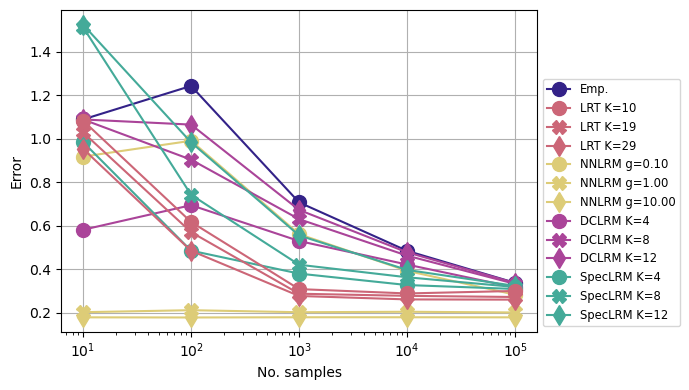

In [16]:
# Compute error of conditional PMFs

clr_list = [muted_qual['indigo'],muted_qual['rose'],muted_qual['sand'],muted_qual['purple'],muted_qual['teal'],muted_qual['wine']]
methods = ['Emp.','LRT','NNLRM','DCLRM','SpecLRM','True']
mkr_list = ['o','X','d','^','P','s']

et = "sin"
et = "sinL"
et = "sinR"
et = "norml1"
et = "l1"
et = "normfrob"
# et = "frob"

fig = plt.figure(figsize=(7,4)); ax = fig.subplots(); ax.grid(1); ax.set_axisbelow(1)
ax.semilogx( T_range, err_obs_P[et].mean(0), mkr_list[0], linestyle='-', c=clr_list[0], label=methods[0], markersize=10, zorder = 4 )
_ = [ax.semilogx( T_range, err_lrt_P[et].mean(1)[i], mkr_list[i], linestyle='-', c=clr_list[1], label=methods[1]+f' K={K_lrt_range[i]}', markersize=10, zorder = 5 ) for i in range(len(K_lrt_range))]
_ = [ax.semilogx( T_range, err_nnlrm_P[et].mean(1)[i], mkr_list[i], linestyle='-', c=clr_list[2], label=methods[2]+f" g={gamma_range[i]:.2f}", markersize=10, zorder = 4 ) for i in range(len(gamma_range))]
_ = [ax.semilogx( T_range, err_dclrm_P[et].mean(1)[i], mkr_list[i], linestyle='-', c=clr_list[3], label=methods[3]+f" K={K_dclrm_range[i]}", markersize=10, zorder = 4 ) for i in range(len(K_dclrm_range))]
_ = [ax.semilogx( T_range, err_slrm_P[et].mean(1)[i], mkr_list[i], linestyle='-', c=clr_list[4], label=methods[4]+f" K={K_slrm_range[i]}", markersize=10, zorder = 4 ) for i in range(len(K_slrm_range))]
ax.set_xlabel('No. samples'); ax.set_ylabel('Error'); ax.legend(); ax.legend(bbox_to_anchor=(1,0),loc='lower left',fontsize='small'); fig.tight_layout()